In [25]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import yfinance as yf

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn import model_selection

from sklearn.neural_network import MLPRegressor

In [263]:
# IMPORT DANYCH Z WYKORZYSTANIEM YFINANCE

data = yf.download('GOOGL', index_col = 0, squeeze = True, parse_dates=['Date'])

#WYSWIETLENIE PIERWSZYCH 5CIU OBSERWACJI Z DANYCH

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044


In [264]:
#SPRAWDZENIE CZY W DANYCH ZNAJDUJĄ SIĘ BRAKUJĄCE WARTOŚCI

data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [265]:
#WYŚWIETLENIE WYMIARÓW DANYCH

data.shape

(4625, 6)

In [266]:
#FILTROWANIE ANALIZOWANYCH DANYCH - NAS INTERESUJE CENA ZAMKNIECIA

data = data['Close']

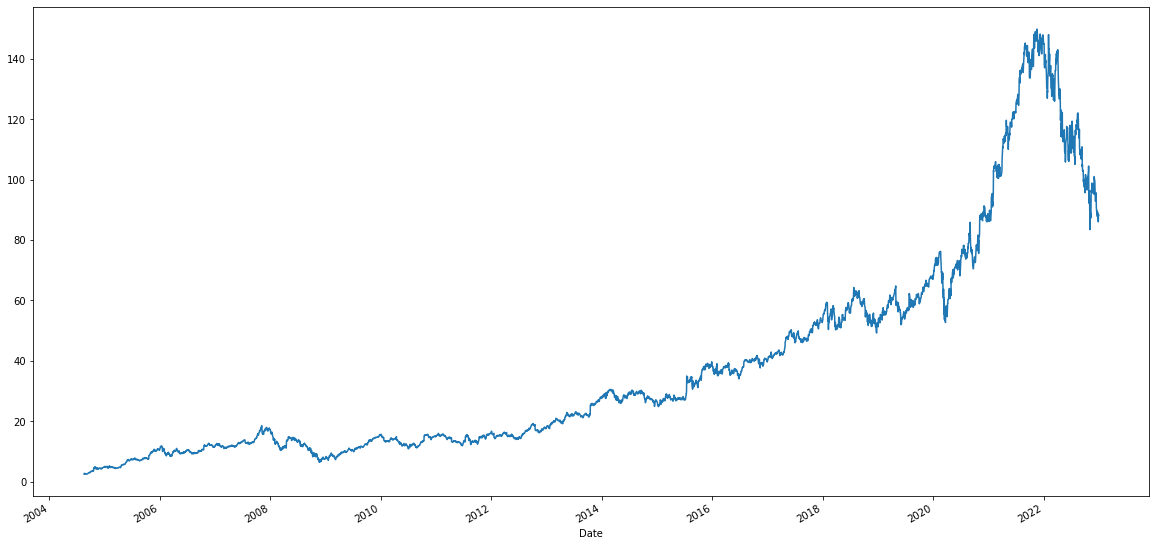

In [267]:
#NARYSOWANIE WYKRESU CENY ZAMKNIECIA W CZASIE

plt.figure(figsize=(20, 10))
data.plot()
plt.show()

In [268]:
from statsmodels.tsa.stattools import adfuller

In [269]:
#ZAIMPORTOWANIE FUNKCJI SPRAWDZAJĄCEJ STACJONARNOŚĆ SZEREGU CZASOWEGO

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()#.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(20,10));
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

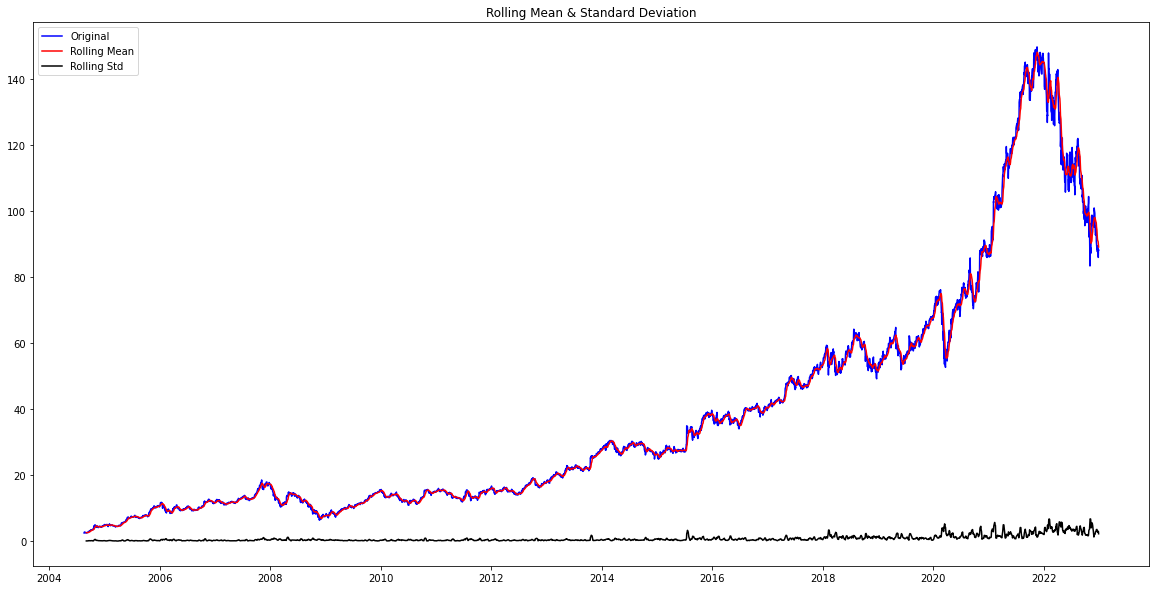

Results of Dickey-Fuller Test:
Test Statistic                   -0.328779
p-value                           0.921328
#Lags Used                       23.000000
Number of Observations Used    4601.000000
Critical Value (1%)              -3.431772
Critical Value (5%)              -2.862168
Critical Value (10%)             -2.567104
dtype: float64


In [270]:
#SPRAWDZENIE STACJONARNOŚCI SZEREGU CZASOWEGO

test_stationarity(data)

In [271]:
#SPRAWDZENIE P-VALUE

_,pval,_,_,_,_ =adfuller(data, autolag='AIC')
pval

0.9213282705356844

In [272]:
#SPRAWDZENIE P-VALUE

if pval > 0.05:
    print('pval > 0.05 -> przyjmujemy hipoteze zerowa -> szereg czasowy jest niestacjonarny')
else:
    print('pval < 0.05 -> odrzucamy hipoteze zerowa -> szereg czasowy jest stacjonarny')

pval > 0.05 -> przyjmujemy hipoteze zerowa -> szereg czasowy jest niestacjonarny


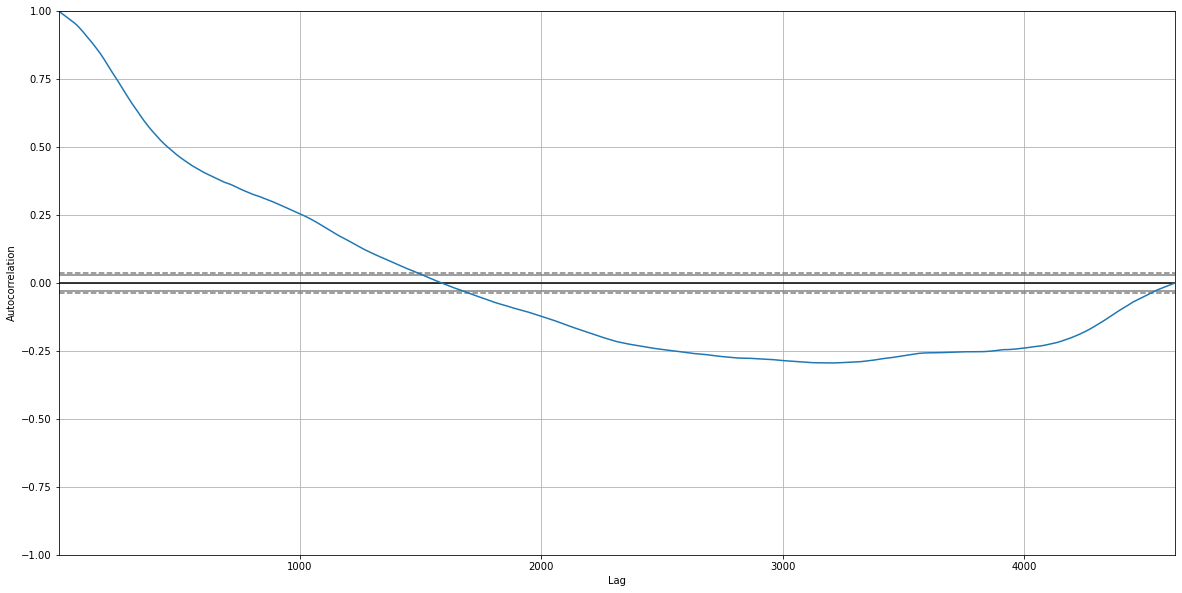

In [273]:
#SPRAWDZENIE AUTOKORELACJI

from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20,10));
autocorrelation_plot(data)
plt.show()

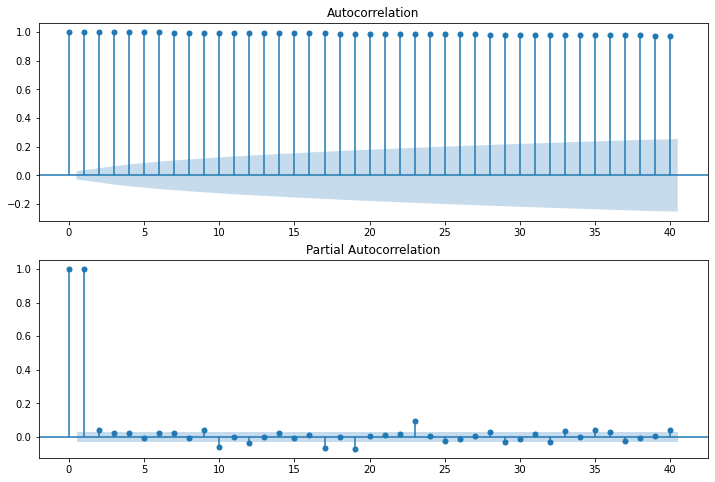

In [274]:
#SPRAWDZENIE AUTOKORELACJI

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.values, lags=40, ax=ax2)
plt.show()

In [275]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [276]:
data_np = data.values
test_data = data.values[-20:]
data = data.values[:-20]

In [277]:
print(test_data.shape)
print(data.shape)

(20,)
(4605,)


In [278]:
df = pd.DataFrame()
df['t'] = [x for x in data]
dataframe = series_to_supervised(df, 15)
dataframe.head()

,var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
15,2.511011,2.710460,2.737738,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,2.540290,2.502753,2.542042,2.560060,2.560310,2.635886
16,2.710460,2.737738,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,2.540290,2.502753,2.542042,2.560060,2.560310,2.635886,2.690190
17,2.737738,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,2.540290,2.502753,2.542042,2.560060,2.560310,2.635886,2.690190,2.790040
18,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,2.540290,2.502753,2.542042,2.560060,2.560310,2.635886,2.690190,2.790040,2.802803
19,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759,2.540290,2.502753,2.542042,2.560060,2.560310,2.635886,2.690190,2.790040,2.802803,2.852102


In [279]:
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]

In [280]:
#PODZIAŁ DANYCH NA CZĘŚĆ TESTOWĄ ORAZ TRENINGOWĄ

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [281]:
#DEFINIOWANIE PARAMETRÓW CROSS-VALIDATION

seed=123
kfold = model_selection.KFold(n_splits=5, random_state=None)

In [282]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ ELASTIC NET
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ANALIZOWANY WSPÓŁCZYNNIK ALFA: 0.01, 0.1, 1, 10
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'elasticnet__alpha': [0.01, 0.1, 1, 10]},
                    cv=kfold,
                    refit=True)
grid_1.fit(X_train, y_train)
grid_1.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2216.3145469454166, tolerance: 350.762449471431
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1962.8532803315895, tolerance: 344.2567796888789
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2131.0847776990454, tolerance: 353.8900763974535
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Con

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2045.2219309741374, tolerance: 347.8563697637195
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2075.749446837512, tolerance: 359.09079954052123
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1776.3017222382855, tolerance: 350.762449471431
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Con

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3043.1321524035725, tolerance: 344.2567796888789
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3237.3963674648257, tolerance: 353.8900763974535
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3226.4187715162097, tolerance: 347.8563697637195
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Co

{'elasticnet__alpha': 0.01, 'polynomialfeatures__degree': 3}

In [283]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ LASSO
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ANALIZOWANY WSPÓŁCZYNNIK ALFA: 0.01, 0.1, 1, 10
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_2 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'lasso__alpha': [0.01, 0.1, 1, 10]},
                    cv=kfold,
                    refit=True)
grid_2.fit(X_train, y_train)
grid_2.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2215.826308803646, tolerance: 350.762449471431
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1963.7979619333105, tolerance: 344.2567796888789
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2132.2682693636702, tolerance: 353.8900763974535
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2180.322905395923, tolerance: 347.8563697637195
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2210.892817096603, tolerance: 359.09079954052123
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1918.9641627634755, tolerance: 350.762449471431
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4376.744743172783, tolerance: 344.2567796888789
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4573.819190550415, tolerance: 353.8900763974535
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4557.731755809005, tolerance: 347.8563697637195
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conve

{'lasso__alpha': 1, 'polynomialfeatures__degree': 1}

In [284]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ RIDGE
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ANALIZOWANY WSPÓŁCZYNNIK ALFA: 0.01, 0.1, 1, 10
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_3 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'ridge__alpha': [0.01, 0.1, 1, 10]},
                    cv=kfold,
                    refit=True)
grid_3.fit(X_train, y_train)
grid_3.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.43443e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.63367e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.5932e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.23827e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.84759e-19): result may n

{'polynomialfeatures__degree': 1, 'ridge__alpha': 10}

In [285]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ REGRESJI WIELOMIANOWEJ
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_4 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression()),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4]},
                    cv=kfold,
                    refit=True)
grid_4.fit(X_train, y_train)
grid_4.best_params_

{'polynomialfeatures__degree': 1}

In [ ]:
#TRENOWANIE MODELU MLP REGRESSOR 

grid_5 = GridSearchCV(MLPRegressor(hidden_layer_sizes=(100,100,100),activation='tanh',alpha=0.0001,max_iter=1000),
                    param_grid={'hidden_layer_sizes': [(1000,1000,1000),(100,100,100),(10,10,10)],
                                'alpha': [1, 10, 100 ,1000],
                               'activation': ['identity', 'logistic', 'tanh', 'relu']                               
                               },
                    cv = kfold,
                    n_jobs=1,
                    refit=True)
grid_5.fit(X_train,y_train)
grid_5.best_params_

In [289]:
#UTWORZENIE LIST OPTYMALNYCH PARAMETRÓW R^2, VAR, MAE, MSE DLA WSZYSTKICH ANALIZOWANYCH METOD

from sklearn import  metrics

models = []
models.append(('ElasticNet', grid_1.best_estimator_))
models.append(('Lasso', grid_2.best_estimator_))
models.append(('Ridge', grid_3.best_estimator_))
models.append(('LR', grid_4.best_estimator_))
models.append(('MLP_R', grid_5.best_estimator_))

r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

ElasticNet
R^2: 0.99909936107297
Explained variance score: 0.9990995511974546
Median absolute error: 0.371542573562504
Mean squared error: 1.171653628725202
Mean absolute errors: 0.6366205824573571
Lasso
R^2: 0.9992127548815306
Explained variance score: 0.9992142205339762
Median absolute error: 0.22790202536947302
Mean squared error: 1.0241380558495157
Mean absolute errors: 0.5419927320903096
Ridge
R^2: 0.9993354422194068
Explained variance score: 0.9993363336698161
Median absolute error: 0.1860416013707571
Mean squared error: 0.864532402232725
Mean absolute errors: 0.47274325104953463
LR
R^2: 0.9993350878222769
Explained variance score: 0.9993359750551992
Median absolute error: 0.18639330333079585
Mean squared error: 0.8649934423575313
Mean absolute errors: 0.47273792812716564
MLP_R
R^2: 0.9990417253169515
Explained variance score: 0.999169000033365
Median absolute error: 0.27959730973224595
Mean squared error: 1.2466327803661652
Mean absolute errors: 0.617274730905358


In [291]:
#UTWORZENIE DATAFRAME PARAMETRÓW R^2, VAR, MAE, MSE DLA WSZYSTKICH ANALIZOWANYCH METOD

d = {'r2': r2, 
     'explained_variance_score': explained_variance_score, 
     'median_absolute_error': median_absolute_error,
     'mean_squared_error' : mean_squared_error,
     'mean_absolute_error' : mean_absolute_error,
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['ElasticNet','Lasso','Ridge', 'LR', 'MLP_R'])
df

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,ElasticNet,0.999099,0.999100,0.371543,1.171654,0.636621
1,Lasso,0.999213,0.999214,0.227902,1.024138,0.541993
2,Ridge,0.999335,0.999336,0.186042,0.864532,0.472743
3,LR,0.999335,0.999336,0.186393,0.864993,0.472738
4,MLP_R,0.999042,0.999169,0.279597,1.246633,0.617275
